In [1]:
from numba import jit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [10]:
#@jit
def simul(N, T, dt, params, random_numbers, init_state=None):
    # Unpack parameters
    mu_x, mu_y, k_x, k_y, k_int, tau, eps = params
    
    # Unpack stochastic variables (needed for numba)
    delta_x = random_numbers[0]
    delta_y = random_numbers[1]
    delta_f = random_numbers[2]

    # Initialize state variables
    x = np.zeros((N, T))
    y = np.zeros((N, T))
    f = np.zeros((N, T))

    # Initial conditions
    if init_state is not None:
        x[:, 0] = init_state[0]
        y[:, 0] = init_state[1]
        f[:, 0] = init_state[2]

    # Time evolution (Langvine dynamics)
    for t in range(T-1):
        dx = mu_x*(-k_x*x[:, t] + k_int*y[:, t])*dt + np.sqrt(2*mu_x*T*dt)*delta_x[:, t]
        dy = mu_y*(-k_y*y[:, t] + k_int*x[:, t] + f[:, t])*dt + np.sqrt(2*mu_y*T*dt)*delta_y[:, t]
        df = -(f[:, t]/tau)*dt + np.sqrt(2*eps**2*dt/tau)*delta_f[:, t]

        x[:, t+1] = x[:, t] + dx
        y[:, t+1] = y[:, t] + dy
        f[:, t+1] = f[:, t] + df
    
    return x, y, f

In [12]:
"""
mu_x = np.array([1, 0, 2])
mu_y = np.array([1, 0, 2])
k_x = np.array([1, 0, 2])
k_y = np.array([1, 0, 2])
k_int = np.array([1, 0, 2])
tau = np.array([1, 1, 2])
eps = np.array([1, 0, 5])
"""

N = int(1e4)
T = 10000

# Define the parameters (drawn from the uniform prior)
mu_x = np.random.uniform(0.1, 0.5, size=N)
mu_y = np.random.uniform(0.1, 0.5, size=N)
k_x = np.random.uniform(0.1, 0.5, size=N)
k_y = np.random.uniform(0.1, 0.5, size=N)
k_int = np.random.uniform(0.1, 0.5, size=N)
tau = np.random.uniform(0.1, 0.5, size=N)
eps = np.random.uniform(0.1, 0.5, size=N)

# Initial state
init_state = [np.random.normal(-20, 20, size=N), np.random.normal(-20, 20, size=N), np.random.normal(-0.5, 0.5, size=N)]

# Generate random numbers for the stochastic variables
delta_x = np.random.normal(0, 1, size=(N, T))
delta_y = np.random.normal(0, 1, size=(N, T))
delta_f = np.random.normal(0, 1, size=(N, T))
random_numbers = [delta_x, delta_y, delta_f]

# Run the N simulations in parallel
x, y, f = simul(N, T, 0.01, [mu_x, mu_y, k_x, k_y, k_int, tau, eps], random_numbers, init_state)

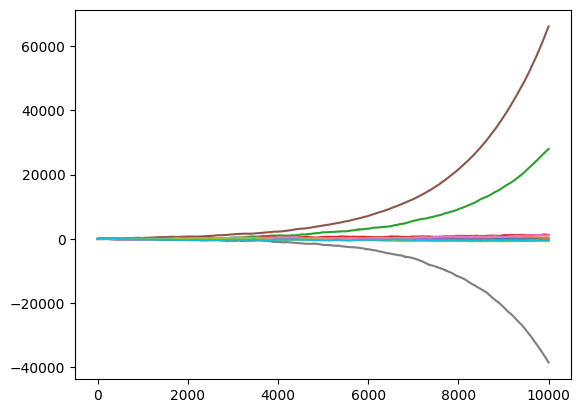

In [15]:
for n in range(min(N, 10)):
    plt.plot(x[n, :], label=f"Trajectory {n}")